# Интеллектуальный анализ данных – весна 2022

# Домашнее задание 7: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов (+1 бонусный балл).


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

<!-- ![](meme.jpg) -->
<img src="meme.jpg" alt="Drawing" style="width: 700px;"/>

## Часть 1: Основы построения решающие дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [2]:
k1 = 8
k2 = 2 
s = k1 + k2 

print(round(-k1/s * np.log2(k1/s) - k2/s * np.log2(k2 / s), 2))

0.72


**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [3]:
def gini(y):
    ps = np.bincount(y) / len(y)
    return np.sum(ps * (1 - ps))

def Q(X, y, j, t, H=gini):
    if X.ndim > 1:
        x = X[:,j] # выделили только признак 
    else:
        x= X 
    left = y[x <= t]
    right = y[x > t]
    count = len(y)
    return H(y) - len(left) / count * H(left) - len(right) / count * H(right)

y = np.array([0] * 8 + [1] * 2) 
X = y.reshape(-1,1)
Q(X, y, 0, 0.5) # вообще очев, будет только H(y), так как разделения чистые и H(left) = H(right) = 0

0.32

**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [4]:
np.array([1, 10, 5, 18, 100, 30, 50, 61, 84, 47]).mean()

40.6

## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [9]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

In [162]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame], 
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`
    
    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """
    # В задании, вроде, логическая ошибка. 
    # Просят использовать критерий информативности, 
    # но надо вернуть критерий Джини и когда он минимален, 
    # подразумевая, что все-таки не по информативности надо максимизировать, 
    # а минимизировать по критерию Джини.

    # Я игнорирую критерий Джини и возвращаю информативность 

    if task == "regression":
        impurity_func = np.var
    elif task == "classification":
        impurity_func = gini 
    else:
        raise ValueError("Чет не то с task")

    if feature_type == "categorical":
        thresholds = np.unique(feature_vector)
        def split(t):
            return Q(feature_vector, target_vector, 0, t, H=impurity_func)
    else:
        thresholds = np.unique(feature_vector) # оно соритурует тоже 
        # трешхолды можно брать как средние между текущими значениями 
        thresholds = np.convolve(thresholds, np.ones(2) * 0.5, 'valid')
        def split(t):
            return Q(feature_vector, target_vector, 0, t, H=impurity_func)

    # фактически это будет жульничеством, но я воспользуюсь np.vectorize 
    # эта функция повзоляет прогнать функцию по каждому значению массива, заменя for
    # зато удовлетворяет условию бонусного задания :)
    ginis = np.vectorize(split)(thresholds)
    best = np.argmax(ginis) # если используем Q, мы максимизируем информативность 
    return thresholds, ginis, thresholds[best], ginis[best]



In [163]:
arr = np.array([0] * 5 + [1] * 3 + [np.NaN] * 7)
y = np.array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1])
find_best_split(arr, y) # Работает с NaN и игнорирует их 

(array([0.5, nan]), array([0.48, 0.48]), 0.5, 0.48)

Эту функцию можно протестировать на датасете `California`.

In [16]:
from sklearn.datasets import fetch_california_housing

In [17]:
data = fetch_california_housing()
X = pd.DataFrame(data=data["data"], columns=data["feature_names"])
y = data["target"]
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [18]:
y

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

Выведите график зависимости значения критерия ~~ошибки~~ информативности от порогового значения при разбиении вершины по признаку `MedInc`.

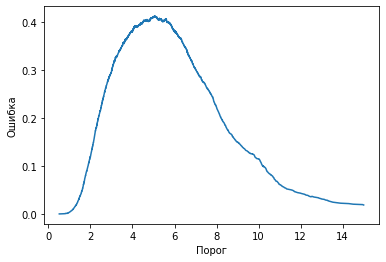

In [19]:
t, g, t_best, g_best = find_best_split(X["MedInc"].values, y, task="regression", feature_type="real")
plt.plot(t, g)
plt.xlabel("Порог")
plt.ylabel("Ошибка")
plt.show()


Найдите лучший, с вашей точки зрения, предикат первой вершины решающего дерева.

In [20]:
X.columns[np.argmax([find_best_split(X[c].values, y, task="regression", feature_type="real")[3] for c in X.columns])]
# Многовато всего, но фактически ищем максимум по критерию информативности и выводим соответствующий столбец 

'MedInc'

**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

В задаче также предлагается получить два бонуса, по баллу на каждый!

- **Реализуйте способ обрабатывать пропуски в даннх и реализуйте его, пояснив свои действия.**
- **Реализуйте метод оценки важности признаков.**

In [390]:
class DecisionTree:
    
    def __init__(
        self, 
        feature_types: Union[List[str], np.ndarray], 
        max_depth: int = None, 
        min_samples_split: int = None, 
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:
        
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}
        
        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types
        self._nan_names = [] # названия для nan
        
        # гиперпараметры дерева
        self._max_depth = max_depth                  # я тут заметил, что они почему-то вообще нигде не используются 
        self._min_samples_split = min_samples_split  # В условиях не сказано, что надо учитывать этот критерий,
        self._min_samples_leaf = min_samples_leaf    # здесь аналогично
        # в итоге я реализовал только max_depth и min_smaples_split, потому что они чаще оказывались полезными параметрами 
        self.task = task
        
        # Переменная, если вы решите делать бонус
        # Записываем для каждого признака сюда его информативность
        self._feature_importances = {}
        

    def _fit_node(
        self, 
        sub_X: np.ndarray, 
        sub_y: np.ndarray, 
        node: dict,
        depth = 0
    ) -> None:
        # критерий останова
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                # здесь могла быть реализация более сложного подхода к обработке категориального признака
                feature_vector = sub_X[:, feature]
            else:
                raise ValueError("type плохой")

            # ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)
            
            
            # если информативност больше: 
            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini

                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    split = feature_vector < threshold
                elif feature_type == "categorical":
                    # в данной реализации это просто значение категории
                    threshold_best = threshold
                    split = feature_vector == threshold
                else:
                    raise ValueError

        # записываем полученные сплиты в атрибуты класса
        if feature_best is None or depth == self._max_depth or (not self._min_samples_leaf is None) and len(sub_y) <= self._min_samples_leaf: # Добавил условие остановки при достижении максимальной глубины :
            node["type"] = "terminal"
            if self.task == "classification":
                node["class"] = Counter(sub_y).most_common(1)[0][0]
            else:
                node["class"] = sub_y.mean()
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError

        if not (feature_best in self._feature_importances):
            self._feature_importances[feature_best] = 0

        self._feature_importances[feature_best] += gini_best / (depth + 1) ** 0.5 # мы прибавляем информативность в лучший критерий разделения
        # Таким образом у самых важных параметров будет больше накопленная информативность 
        # Делим на глубину ( как конкретно - не принципиально ), так как при большой глубине склонно пройтись по всем параметрами и глубоко лежащие критерии мение информативны 

        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"], depth + 1)
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"], depth + 1)

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        if node["type"] == "terminal":
            return node["class"]
        if self._feature_types[node["feature_split"]] == "real":
            if x[node["feature_split"]] < node["threshold"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])
        if x[node["feature_split"]] == node["category_split"]:
            return self._predict_node(x, node["left_child"])
        return self._predict_node(x, node["right_child"])

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        X_copy = np.copy(X)
        for i, f in enumerate(self._feature_types):
            nans = pd.isnull(X[:,i])
            nan_name = "" 
            if f == "categorical" and nans.any():
                uniques = np.unique(X[:,i]) # берем все уникальные 
                nan_name = "~" + ''.join(map(str, uniques)) # гарантирует, что замена имени для nan будет уникальной 
                X_copy[:,i][nans] = nan_name # выдаст ошибку, если кто-то решит обозначать классы цифрами, например через Label Encoding 
                # В задании уточнения про это нет, предполагаем, что категории задаются строкой 
            self._nan_names.append(nan_name)
        self._fit_node(X_copy, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        X_copy = np.copy(X)
        for i, f in enumerate(self._feature_types):
            nans = pd.isnull(X[:,i])
            if f == "categorical" and nans.any():
                X_copy[:,i][nans] = self._nan_names[i] # если nan, используем нашу нулевую категорию
            else: 
                X_copy[:,i][nans] = X_copy[:,i].mean() # присвоить категорию признаку среди чисел тяжело, поэтому просто обработаем так 
        for x in X_copy:
            predicted.append(self._predict_node(x, self._tree))
            
        return np.array(predicted)

**Задание 2.3 (1 балл)** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

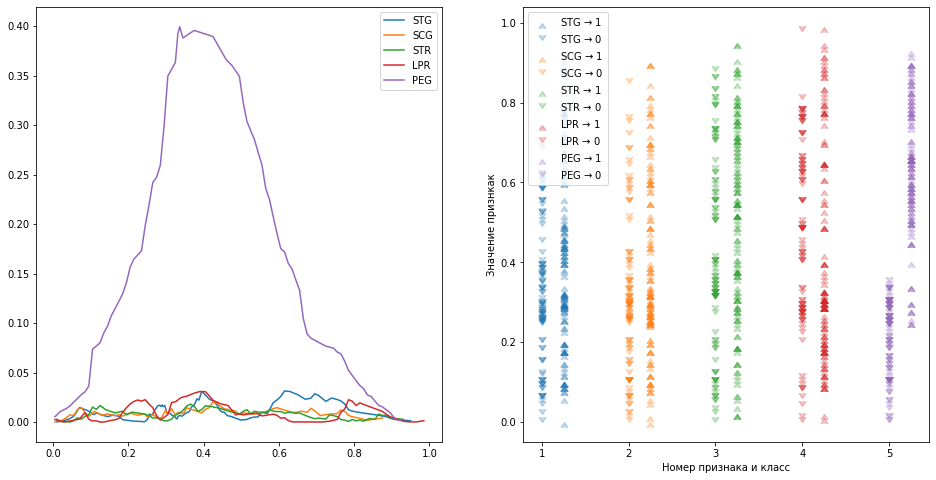

In [359]:
data = pd.read_csv("./students.csv")
data.isna().any().any() # False 
y = data["UNS"]
labels = data.columns[1:-1]
X = np.array(data[labels])

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
c = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i in range(5):
    t, g, b_t, b_g = find_best_split(X[:, i], y)
    ax[0].plot(t, g, label=labels[i])
    pos = y == 1 
    ax[1].scatter([i + 1.25] * len(y[pos]), X[pos,i],  s=50, marker=6, alpha=0.25, label=labels[i] + " $\\to$ 1", color=c[i])
    ax[1].scatter([i + 1 ] * len(y[~pos]), X[~pos,i],  s=50, marker=7, alpha=0.25, label=labels[i] + " $\\to$ 0", color=c[i])
ax[0].legend()
ax[1].legend()
ax[1].set_xlabel("Номер признака и класс")
ax[1].set_ylabel("Значение признкак")
plt.show()


Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

**Ответ:** По графику справа (Scatter Plot здесь не очень подходит, так что он чуть-чуть стилизован) видно, что лучше всего выборка разделяется по переменной `PEG` в районе 0.4. Это подтерждается максимумом информативности на графике слева, который тоже наблюдается в случае с параметром `PEG` при пороге ~0.39. Таким образом данный порог и параметр являются лучшим вариантом проведения разбиения. 

У кривых с хорошим вариантом разделения будет один резкий пик. Чем он выше и чем меньше его ришина, тем лучше будет разделение по этому параметру. У кривых, по которым деление происходит плохо, можно увидеть несколько пиков, так как разделение не чистое и можно лишь локально разделить выборку на нужные классы. Тем не менее, наличие нескольких пиков информативности говорит о том, что необходимое разбиение можно провести несколько раз (то есть построить дерево) и повысить итоговое качество разделения классов.

**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). 

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), 
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа. 

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [360]:
data = pd.read_csv("./agaricus-lepiota.data", header=None)
y = np.array(data[0].apply(lambda x: 0 if x == "e" else 1))
X = np.array(data[data.columns[1:]])

In [361]:
from sklearn.preprocessing import LabelEncoder
les = []
for i in range(X.shape[1]):
    les.append(LabelEncoder())
    X[:,i] = les[-1].fit_transform(X[:,i])

In [362]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [363]:
from sklearn.metrics import accuracy_score

tree = DecisionTree(["categorical"] * X.shape[1])
tree.fit(X_train, y_train)


In [364]:
print(accuracy_score(y_test, tree.predict(X_test)))

1.0


## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [365]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [366]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

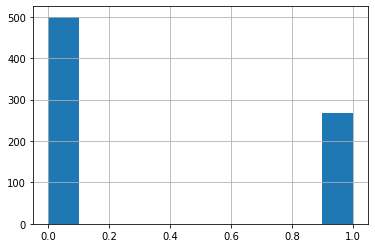

In [367]:
data['Outcome'].hist()
plt.show()

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [368]:
y = np.array(data["Outcome"])
X = np.array(data[data.columns[:-1]])

X_res, X_test, y_res, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_res, y_res, test_size=0.3, random_state=42)

X_train.shape, X_test.shape, X_valid.shape 

((375, 8), (231, 8), (162, 8))

**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке. 


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [369]:
depth = np.arange(5, 30)
leafs = np.arange(1, 10)
pipline = np.array([[[d, l] for l in leafs] for d in depth]).reshape(1, -1, 2)[0]

pipline = [{"max_depth": i[0], "min_samples_leaf": i[1]} for i in pipline] # трансформируем пайплайн в параметры 

best = {
    "tree": None, "score": None, "params" : None
}
for p in pipline:
    tree = DecisionTreeClassifier(**p, random_state=31415) # развернули параметры в модель 
    tree.fit(X_train, y_train)
    score = f1_score(y_valid, tree.predict(X_valid))
    if best["score"] is None or score < best["score"]:
        best["params"] = p  
        best["tree"] = tree
        best["score"] = score 

print(best["params"], round(best["score"],2))


{'max_depth': 11, 'min_samples_leaf': 1} 0.49


In [370]:

tree = best["tree"]
tree.fit(X_res, y_res)

y_pred = tree.predict(X_test)
y_true = y_test 

print(f"Accuracy: {accuracy_score(y_true, y_pred)}")
print(f"Precision: {precision_score(y_true, y_pred)}")
print(f"Recall: {recall_score(y_true, y_pred)}")
print(f"AUC-ROC: {roc_auc_score(y_true, y_pred)}")

Accuracy: 0.7142857142857143
Precision: 0.5714285714285714
Recall: 0.7
AUC-ROC: 0.7109271523178808


Метрики норм. Использовать модель для диагностики диабета все же вряд ли выйдет :\

**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [333]:
bag = BaggingClassifier(n_estimators=50)
bag.fit(X_res, y_res)

y_pred = bag.predict(X_test)
y_true = y_test 

print(f"Accuracy: {accuracy_score(y_true, y_pred)}")
print(f"Precision: {precision_score(y_true, y_pred)}")
print(f"Recall: {recall_score(y_true, y_pred)}")
print(f"AUC-ROC: {roc_auc_score(y_true, y_pred)}")

Accuracy: 0.7575757575757576
Precision: 0.6428571428571429
Recall: 0.675
AUC-ROC: 0.7381622516556291


Не сильно лучше, но увеличился Presision, что делает его более чувствительным к диабету. Чуть лучше для этих целей.

**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации. 
3. Выберите ту пару значений, которая даёт наилучшее среднее качество. 

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [342]:
from sklearn.model_selection import cross_val_score
from IPython.display import clear_output

# взял функцию из старого кода для контроля прогресса
def draw_bar(progress, count, name=""):
    clear_output(wait=False)
    print(f"{name}: [{'=' * (progress // 4)}>{' ' * (25 - progress // 4)}] - {str(progress).center(3)}% - Обучено: {count}", end="\r", flush=True)


best = {
    "est": None, "score": None, "params" : None
}
for i, p in enumerate(pipline):
    progress = round(i / len(pipline) * 100) 
    draw_bar(progress=progress, count=i+1, name="Валидация")
    estimator = RandomForestClassifier(50, **p, random_state=42)
    cross = cross_val_score(estimator, X_res, y_res, scoring="f1")
    score = cross.mean() + cross.std() # добавляем дисперсию, чтобы также минимизировать разбросс модели в валидации  
    if best["score"] is None or score < best["score"]:
        best["params"] = p  
        best["est"] = tree
        best["score"] = score 
print()
print(best["score"], best["params"])

0.6421606568802396 {'max_depth': 7, 'min_samples_leaf': 9}бучено: 225


In [343]:
estimator = best["est"]
estimator.fit(X_res, y_res)
y_pred = estimator.predict(X_test)
y_true = y_test 

print(f"Accuracy: {accuracy_score(y_true, y_pred)}")
print(f"Precision: {precision_score(y_true, y_pred)}")
print(f"Recall: {recall_score(y_true, y_pred)}")
print(f"AUC-ROC: {roc_auc_score(y_true, y_pred)}")

Accuracy: 0.7142857142857143
Precision: 0.5714285714285714
Recall: 0.7
AUC-ROC: 0.7109271523178808


На мой взгляд, лучше всего себя показал Бэггинг, но у него был худший Recall. Если бы нас интересовала в первую очередь эта метрика (хотя в случае с диабетом может она и не лучшая), то лучше оказался бы лес (хотя по факту это такая же реализация бэггинга, только для деревьев).

**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

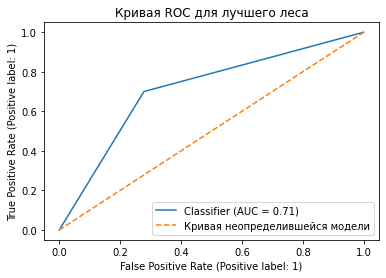

In [351]:
from sklearn.metrics import RocCurveDisplay 
RocCurveDisplay.from_predictions(y_true, y_pred)
plt.plot([0, 1], [0 , 1], "--", label="Кривая неопределившейся модели")
plt.legend()
plt.title("Кривая ROC для лучшего леса")
plt.show()

Модель однозначно не является хорошим классификатором диабета и ложно диагностирует почти всех подряд, хотя для некоторых случае все же дает доставерный результат.

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

Самый важный признак для диагностики диабета: Glucose


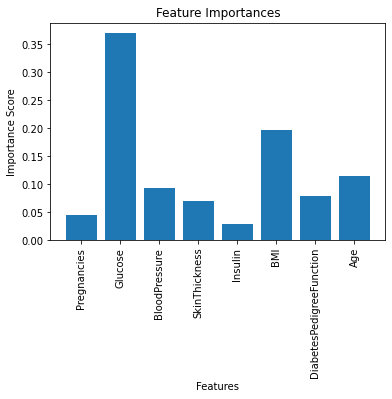

In [356]:
importances = estimator.feature_importances_
plt.bar(data.columns[:-1], importances)
plt.xticks(rotation=90)
plt.ylabel('Importance Score')
plt.xlabel('Features')
plt.title('Feature Importances')

# Identify the most important feature
most_important_feature = data.columns[importances.argmax()]
print('Самый важный признак для диагностики диабета:', most_important_feature)

Глюкоза действительно является первым параметром, по которому пациенту ставят предварительный диагноз перед полным обследованием. Этот параметр напрямую связан с способностью организма разлогать сахары. Модель дала ему наибольшую важность.